In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import os 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [157]:
np.set_printoptions(suppress=True)


## Data Loading

In [158]:
data = pd.read_csv("Autism_Prediction/train.csv")
test_data = pd.read_csv("Autism_Prediction/test.csv")

In [159]:
data.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [160]:
test_data.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self


In [161]:
scores = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
          'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

In [162]:
x_train = data[scores].astype(np.float32)
y_train = data["Class/ASD"].values.astype(np.float32)

In [163]:
x_test = test_data[scores].astype(np.float32)
y_test = (test_data["austim"].values == "yes").astype(np.float32)

## Model Fitting

In [164]:
lr_fit = LogisticRegression().fit(x_train, y_train)

In [165]:
lr_fit.coef_

array([[-0.00876888,  0.42359275,  0.6588415 ,  1.00784535,  0.61545609,
         1.11793227,  0.4745065 ,  0.66591306,  1.06625923,  0.22407765]])

In [166]:
preds = lr_fit.predict(x_train)


In [167]:
avg_error_class = np.mean(preds == y_train)
print(f"Classification success rate: {avg_error_class}")

Classification success rate: 0.865


In [168]:
preds = lr_fit.predict_proba(x_train)[:,1]
threshold = .6
preds = (preds >= threshold).astype(y_train.dtype)

acc = np.mean(preds == y_train)
acc

0.87375

## Model Validation

## Understanding the ROC Curve

The **Receiver Operating Characteristic (ROC)** curve is a graphical representation used to evaluate the performance of a binary classification model. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings. Below is a an illustration of the ROC:


<img src="https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg" alt="ROC Curve" width="400"/>


- **True Positive Rate (TPR)**: Also known as sensitivity or recall, it measures the proportion of actual positives correctly identified.

$$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

- **False Positive Rate (FPR)**: It measures the proportion of actual negatives that were incorrectly classified as positive.
$$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
$$


### Interpretation
- A model with an AUC close to 1.0 is highly capable of distinguishing between classes.
- A model with an AUC near 0.5 performs no better than random chance.

The ROC curve is useful for visualizing the trade-off between sensitivity and specificity across different thresholds.


In [169]:
probs = lr_fit.predict_proba(x_train)[:,1]



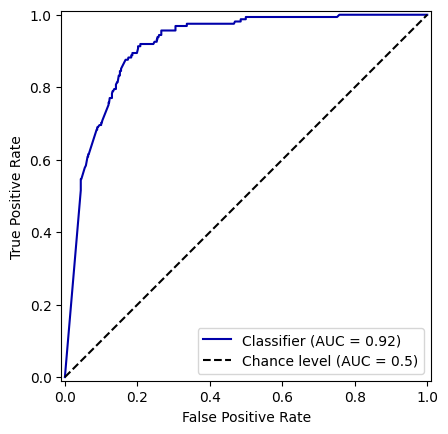

In [170]:
display = RocCurveDisplay.from_predictions(
    y_train,
    probs,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

## Understanding the Confusion Matrix

The **Confusion Matrix** is a table that summarizes the performance of a classification model by comparing the predicted labels with the actual labels. It provides a detailed breakdown of correct and incorrect classifications for each class.

### Structure of a Confusion Matrix:
|                | **Predicted: Positive** | **Predicted: Negative** |
|----------------|--------------------------|--------------------------|
| **Actual: Positive** | True Positive (TP)        | False Negative (FN)        |
| **Actual: Negative** | False Positive (FP)       | True Negative (TN)         |

### Memory items:
1. **True Positive (TP)**: Cases where the model correctly predicts the positive class.
2. **False Negative (FN)**: Cases where the model fails to predict the positive class (misses a positive case).
3. **False Positive (FP)**: Cases where the model incorrectly predicts the positive class (false alarm).
4. **True Negative (TN)**: Cases where the model correctly predicts the negative class.

### Some Metrics Derived from the Confusion Matrix:
- **Accuracy**: The overall correctness of the model.
$$
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- **Precision**: The proportion of positive predictions that are actually correct.
$$
  \text{Precision} = \frac{TP}{TP + FP}
$$

- **Recall (Sensitivity)**: The proportion of actual positives that are correctly identified.
$$
  \text{Recall} = \frac{TP}{TP + FN}
$$

- **F1-Score**: The harmonic mean of precision and recall.
$$
  \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$


In [171]:
cm = confusion_matrix(y_train, preds)

In [172]:
lr_display = ConfusionMatrixDisplay(cm)

## Using the "Clinical Score"

Clinical test accuracy: 0.77375
Regression accuracy: 0.87375


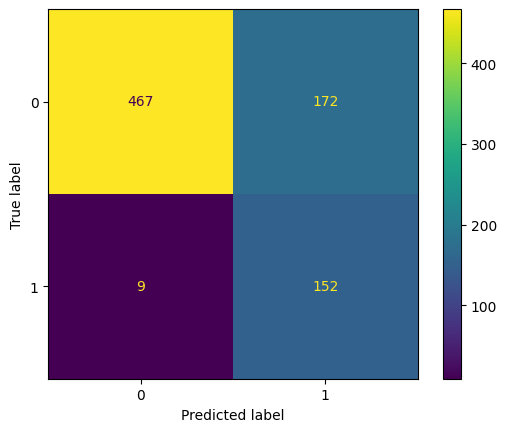

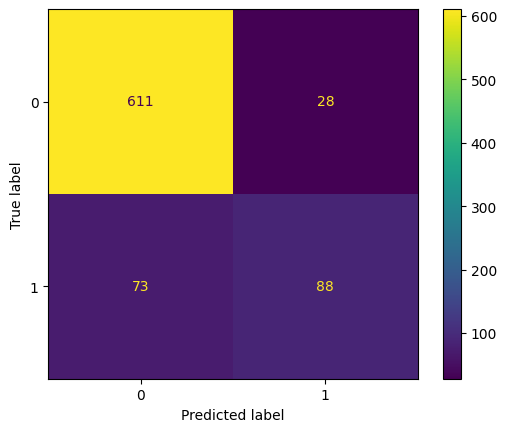

In [173]:
clinical_test_results = (x_train.sum(axis=1) >= 6).astype(y_train.dtype)
clinical_cm = confusion_matrix(y_train, clinical_test_results)
clinical_display = ConfusionMatrixDisplay(clinical_cm)

clinical_display.plot()
lr_display.plot()

clinical_acc = np.mean(clinical_test_results == y_train)

print(f"Clinical test accuracy: {clinical_acc}")
print(f"Regression accuracy: {acc}")

In [174]:
np.mean(preds == clinical_test_results)

0.74

### Going Deep With Neural Networks

In [175]:
nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Spe fy the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compiling the model
nn_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Training the model
history = nn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=150)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7143 - loss: 0.6521
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.4668 
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8727 - loss: 0.2989 
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.3084 
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8570 - loss: 0.2904 
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8791 - loss: 0.2675 
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8625 - loss: 0.2728 
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.2730 
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8605 - loss: 0.2843 
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8525 - loss: 0.2828 
Epoch 11/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8726 - loss: 0.2439 
Epoch 12/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [176]:
# Spe fy the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [177]:
# Compiling the model
nn_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [178]:
# Training the model
history = nn_model.fit(x=x_train, y=y_train, batch_size=32, epochs=150)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9003 - loss: 0.1840
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9056 - loss: 0.1753 
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8982 - loss: 0.1853 
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9091 - loss: 0.1682 
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9065 - loss: 0.1821 
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8969 - loss: 0.1849 
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9155 - loss: 0.1638 
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9141 - loss: 0.1663 
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8953 - loss: 0.1793 
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9040 - loss: 0.1797 
Epoch 11/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9022 - loss: 0.1864 
Epoch 12/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [179]:
nn_model_probs = nn_model.predict(x_train)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


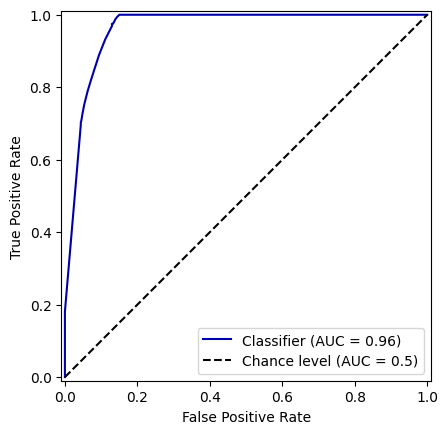

In [180]:
display = RocCurveDisplay.from_predictions(
    y_train,
    nn_model_probs,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

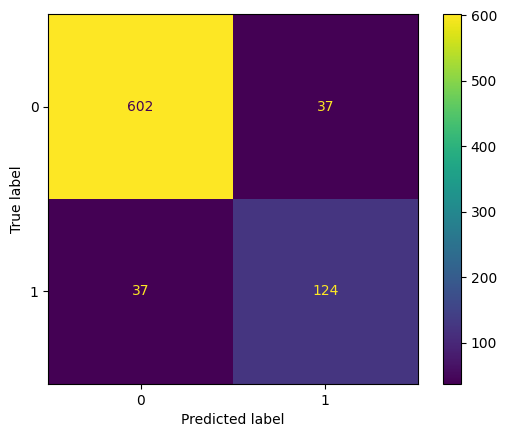

In [181]:
nn_model_cm = confusion_matrix(y_train, (nn_model_probs > 0.5).astype(y_train.dtype))
nn_model_display = ConfusionMatrixDisplay(nn_model_cm)
nn_model_display.plot()


In [182]:
nn_model_test_probs = nn_model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


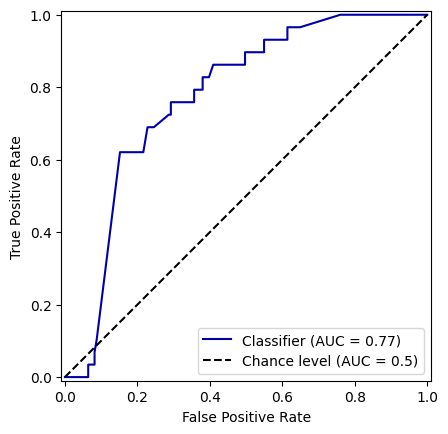

In [183]:
display = RocCurveDisplay.from_predictions(
    y_test,
    nn_model_test_probs,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

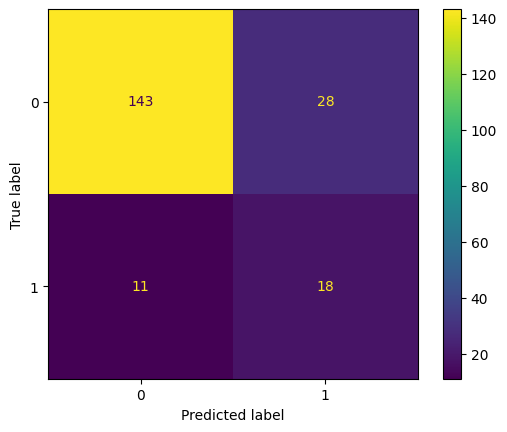

In [184]:
nn_model_test_cm = confusion_matrix(y_test, (nn_model_test_probs > 0.6).astype(y_train.dtype))
nn_model_test_display = ConfusionMatrixDisplay(nn_model_test_cm)
nn_model_test_display.plot()

In [185]:
lr_test_probs = lr_fit.predict_proba(x_test)[:,1]


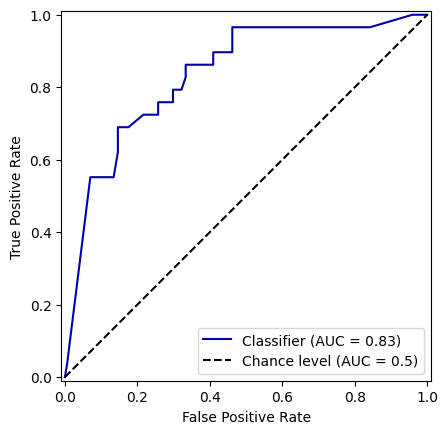

In [186]:
display = RocCurveDisplay.from_predictions(
    y_test,
    lr_test_probs,
    color="#0000AA",
    plot_chance_level=True,
)

_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)

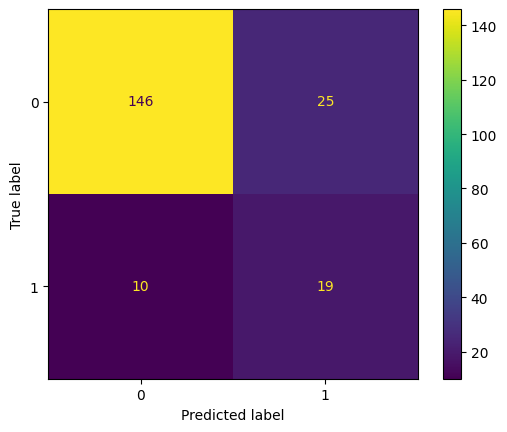

In [187]:
lr_model_test_cm = confusion_matrix(y_test, (lr_test_probs > 0.5).astype(y_train.dtype))
lr_model_test_display = ConfusionMatrixDisplay(lr_model_test_cm)
lr_model_test_display.plot()

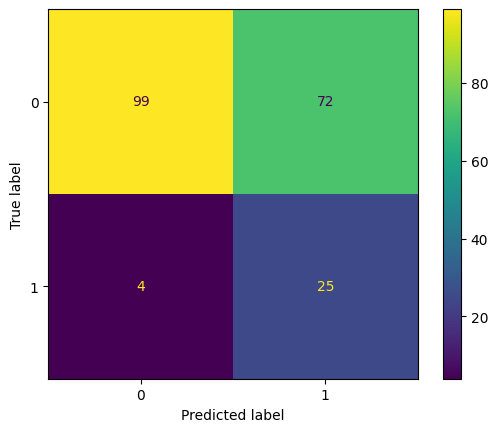

In [188]:
clinical_test_cm = confusion_matrix(y_test, (x_test.sum(axis=1) >= 6).astype(y_test.dtype))
clinical_test_display = ConfusionMatrixDisplay(clinical_test_cm)
clinical_test_display.plot()

In [189]:
# Truth
true_vals = np.hstack((y_train, y_test))

# Various model predictions
clinical_vals = np.hstack(((x_train.sum(axis=1) >= 6).astype(y_train.dtype), (x_test.sum(axis=1 )>= 6).astype(y_train.dtype)))
lm_vals = np.hstack((lr_fit.predict(x_train), lr_fit.predict(x_test)))

threshold = 0.6
nn_vals = np.hstack(((nn_model.predict(x_train).flatten() >= threshold).astype(y_train.dtype), (nn_model.predict(x_test).flatten() >= threshold).astype(y_train.dtype)))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [190]:
output_df = pd.DataFrame({
    'true': true_vals, 
    'clinical': clinical_vals,
    'linear': lm_vals,
    'nn': nn_vals
})

output_df.to_csv('../../autism_predictions.csv', sep=";", index=False)


Problem 5 Part 2 (All code before this section is attributed to Chris Arndt)

In [ ]:
#probs
#nn_model_probs
#clinical_test_results




moe_train = np.column_stack((probs, nn_model_probs, clinical_test_results))

clinical_test_results = (x_test.sum(axis=1) >= 6).astype(y_test.dtype)
moe_test = np.column_stack((lr_test_probs,nn_model_test_probs,clinical_test_results))


Problem 5 Part 3

In [209]:
rf_model = RandomForestClassifier()
rf_model.fit(moe_train, y_train)

rf_pred = rf_model.predict(moe_test)


moe_acc = np.mean(rf_pred == y_test)

moe_acc

#moe_preds = rf_model.predict()



0.785

Problem 5 Part 4

In [208]:
straight_rf = RandomForestClassifier()

straight_rf.fit(x_train, y_train)

straight_preds = straight_rf.predict(x_test)

straight_acc = np.mean(straight_preds == y_test)

straight_acc

0.805

Compared to the Mixture of experts approach, running the random forest directly on the dataset creates slightly higher accuracy. Compared to the models individually, both performed worse. Aggregating the models may be adding more complexity than necessary, though it may be more likely that the individual models were overfitted.